# <center>Курсовая работа<center>

### Подключение библиотек и скриптов

Если не установлено, то:

!pip install xgboost

!pip install lightgbm

!pip install catboost

In [1]:
import pandas as pd
import numpy as np
import pickle
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [4]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [7]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [8]:
#Функция обрабатывает пропущенные наблюдения.
def isna_values(df):

    isna_values = df.isna().sum()
    isna_values_perc = 100 * isna_values / len(df)
    table = pd.concat([isna_values, isna_values_perc], axis=1)
    table_columns = table.rename(columns = {0: 'Количество пропущенных', 1: '%'})
    table_columns = table_columns[table_columns.iloc[:,1] != 0].sort_values('%', ascending=False).round(1)
    
    return table_columns

In [391]:
# Функция обработки признака Home Ownership (уменьшение количества классов и изменение на численный признак)
def fix_home_ownership(df):
    
    column = 'Home Ownership'
    
    df.loc[df[column] == 'Have Mortgage', column] = 'Home Mortgage'
    df = pd.concat([df, pd.get_dummies(df[column])], axis=1)
    
    return df

In [385]:
# Функция обработки признака Purpose для изменение на численный признак
def fix_purpose(df):
    
    column = 'Purpose'
    
    df[column] = df[column].replace({'renewable energy': 'business loan'})
    df = pd.concat([df, pd.get_dummies(df[column])], axis=1)
    
    return df

In [11]:
# Функция конвертирования категориального призака 'Years in current job' в численный
def fix_years_in_current_job(df):

    column = 'Years in current job'
    
    for i in df[column].unique().tolist():
        if i == i:
            if i == '< 1 year':
                df.loc[df[column] == i, column] = 0
            else:
                df.loc[df[column] == i, column] = int(''.join(filter(str.isdigit, i)))
                
    df[column].fillna(df[column].median(), inplace=True)
    
    return df

In [392]:
# Функция конвертации Term из категориального признака к бинарным значениям.
def fix_term(df):

    column = 'Term'
    
    df = pd.concat([df, pd.get_dummies(df[column])], axis=1)
    
    return df

In [402]:
# Функция обработки Current Loan Amount от выбросов 
def fix_current_loan_amount(df):
    
    column = 'Current Loan Amount'
    column2 = 'Purpose'
    column3 = 'Term'
    new_column = 'Current_Loan_Amount_Med'
    value = df[column].max()
    
    df[new_column] = df[column]
    df.loc[df[column] == value, new_column] = df.groupby([column2, column3])[column].transform(lambda x: x.median())
    
    return df

In [15]:
# Функция обработки Maximum Open Credit от выбросов
def fix_maximum_open_credit(df):
    
    column = 'Maximum Open Credit'
    column2 = 'Current_Loan_Amount_Med'
    value = df[column].nlargest(5).min()
    
    df.loc[(df[column] >= value), column] = df[column].quantile(.975)
    df.loc[(df[column] == 0), column] = df[column2]
    
    return df

In [16]:
# Функция обработки Credit Score от выбросов и пропусков
def fix_credit_score(df):
    
    column = 'Credit Score'
    new_column = 'Credit_Score_exist'
    value = 850

    df.loc[df[column] > value, column] = df[column]/10
    df[new_column] = 0
    df.loc[df[column].isnull(), new_column] = 1
    df[column].fillna(df[column].median(), inplace=True)

    return df

In [17]:
# Функция обработки Monthly Debt от выбросов
def fix_monthly_debt(df):
    
    column = 'Monthly Debt'
    value = 0

    df.loc[(df[column] == value), column] = df[column].median()

    return df

In [18]:
# Функция обработки пропусков Bankruptcies
def fix_bankruptcies(df):
    
    column = 'Bankruptcies'
    column2 = 'Number of Credit Problems'
    
    df.loc[df[column].isna(), column] = df.groupby([column2])[column].transform(lambda x: x.median())
    
    return df

In [19]:
# Функция обработки пропусков  Annual Income
def fix_annual_income(df):
    
    column = 'Annual Income'
    column2 = 'Monthly Debt'
    new_column = 'Annual_Income_exist'
    
    df[new_column] = 0
    df.loc[df[column].isna(), new_column] = 1
    df.loc[df[column].isna(), column] = df.groupby([column2])[column].transform(lambda x: x.median())
    df[column].fillna(int(df[column].median()), inplace=True)
    
    return df

In [20]:
# Функция обработки пропусков Months since last delinquent
def fix_months_since_last_delinquent(df):
    
    column = 'Months since last delinquent'
    new_column = 'Months_since_last_delinquent_exist'
    value = 0
    
    df[new_column] = 0
    df.loc[df[column].isna(), new_column] = 1
    df.loc[df[column].isna(), column] = value
    
    return df

In [56]:
# Функция оптимизации типа наблюдений из float в int
def isint(df): 

    for column in df.select_dtypes(include = ['int64', 'float64', 'uint8']).columns.tolist():
        count = 0
        try:
            for number in df[column].tolist():
                if float(number) != int(number):
                    count += 1
                if count == 0:
                    df[column] = df[column].astype(int)
        except ValueError:
            print(f'Есть пропуски в {column}, невозможно обработать')
            
    return df

In [23]:
# Функция конвертации из object в int
def categorial(df): 

    value = 'object'
    CAT_FEATURE_NAMES = df.select_dtypes(include = value).columns.tolist()
    
    for column in CAT_FEATURE_NAMES:
        df[column] = pd.Categorical(df[column])
            
    return df

In [401]:
# Построение модели
def Preprocessing(df):
    df = fix_home_ownership(df)
    df = fix_purpose(df)
    df = fix_years_in_current_job(df)
    df = fix_term(df)
    df = fix_current_loan_amount(df)
    df = fix_maximum_open_credit(df)
    df = fix_credit_score(df)
    df = fix_monthly_debt(df)
    df = fix_annual_income(df)
    df = fix_bankruptcies(df)
    df = fix_months_since_last_delinquent(df)
    df = isint(df)
    df = categorial(df)
    return df

In [393]:
# Функция отбора признаков
def feature_split(df):
    def getName(arg):
        gl = globals().copy()
        for i in gl:
            if gl[i] is arg:
                return i
    ALL = [TARGET_NAME, BASE_FEATURE_NAMES, NEW_FEATURE_NAMES, CAT_FEATURE_NAMES, NUM_FEATURE_NAMES]

    for features in ALL:
        if features == ALL[0]:
            print(getName(features) + '\n' + '\n\n' + str(features) + '\n' + '*' * 100 + '\n')
        else:
            print(getName(features) + '\n' + str(df[features].shape[1]) + '\n\n' + str(features) + '\n' + '*' * 100 + '\n')

### Загрузка данных

In [26]:
# input
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

# output
MODEL_FILE_PATH = './model.pkl'

### Описание датасета
* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [27]:
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [28]:
print(f'Строк в трейне: {df_train.shape[0]}, Столбцов в трейне: {df_train.shape[1]}')
print(f'Строк в тесте: {df_test.shape[0]}, Столбцов в тесте: {df_test.shape[1]}')

Строк в трейне: 7500, Столбцов в трейне: 17
Строк в тесте: 2500, Столбцов в тесте: 16


In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [30]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Обзор данных

In [31]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
CAT_FEATURE_NAMES = df_train.select_dtypes(include = 'object').columns.tolist()
NUM_FEATURE_NAMES = list(set(BASE_FEATURE_NAMES) - set(CAT_FEATURE_NAMES))
NUM_FEATURE = df_train[BASE_FEATURE_NAMES].select_dtypes(include = ['float64', 'int64'])

In [32]:
# Обзор категориальных признаков
for cat_colname in CAT_FEATURE_NAMES:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

In [33]:
# Обзор пропусков
isna_values(df_train)

,Количество пропущенных,%
Months since last delinquent,4081,54.4
Annual Income,1557,20.8
Credit Score,1557,20.8
Years in current job,371,4.9
Bankruptcies,14,0.2


- В признаке Home Ownership видим, что для 12 наблюдений (0,16%) допущена ошибка (Have Mortgage можно заменить на Home Mortgage) и количество групп можно уменьшить до 3х, после чего привести данный признак в численный.
- Признак Years in current job приведем из категориального в численных, при этом значения <1 приравняем 0, а значения 10+ = 10. А также заполним пропуски (< 5%) медианой.
- Признак Term приведем к бинарным значениям.

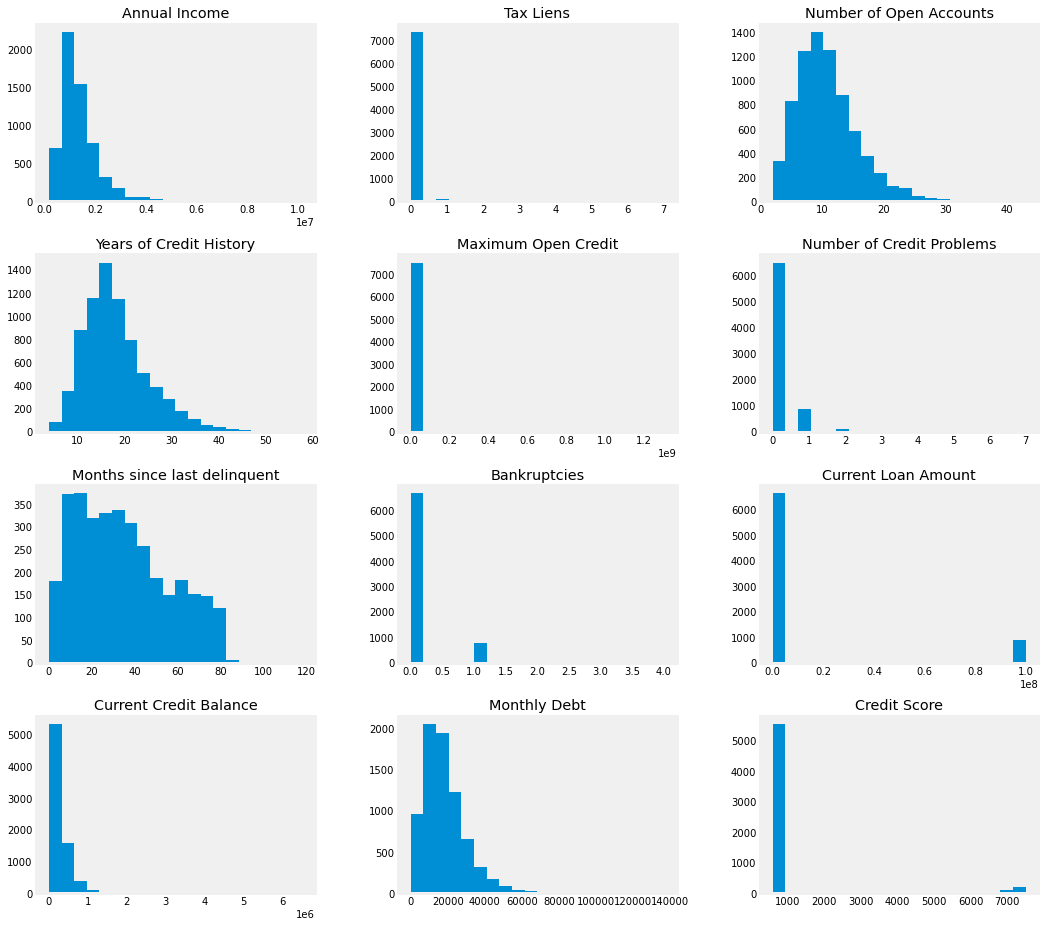

In [34]:
NUM_FEATURE.hist(figsize=(16,16), bins=20, grid=False);

### Корреляция признаков

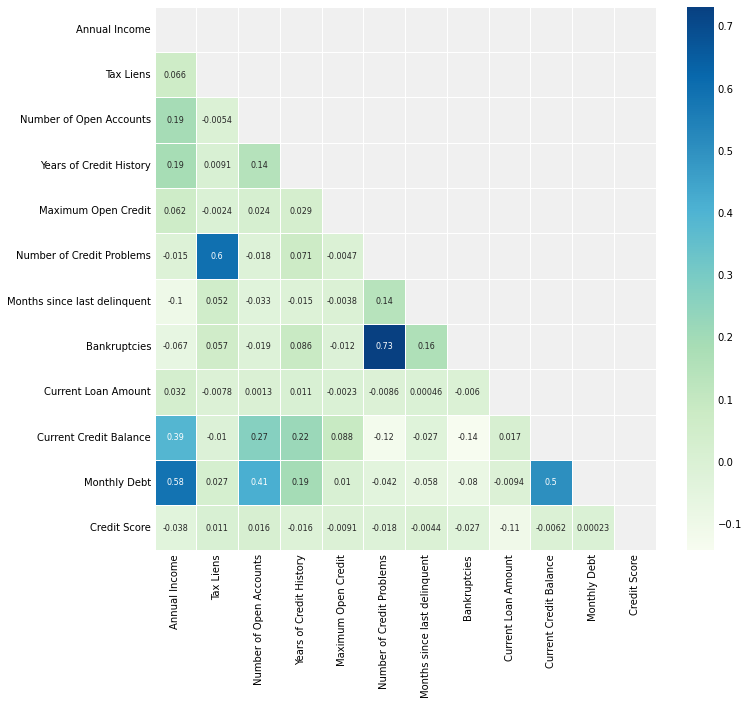

In [37]:
correlation = pd.DataFrame(NUM_FEATURE).corr()
plt.figure(figsize = (10, 10))
mask = np.zeros_like(correlation, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(correlation, mask = mask, annot = True, linewidths = .5, annot_kws = {"size":8}, cmap='GnBu')
plt.show()

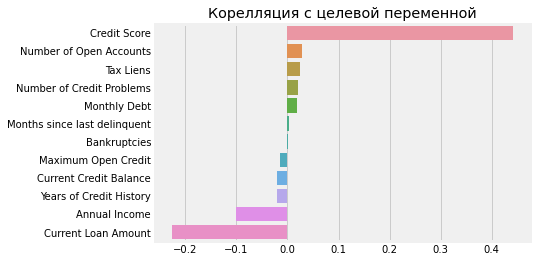

In [38]:
# Корелляция с целевой переменной

correlation_with_target = df_train.corr().iloc[:-1, -1].sort_values(ascending = False)
sns.barplot(x = correlation_with_target.values, y = correlation_with_target.index)

plt.title('Корелляция с целевой переменной')
plt.show()

### Обработка выбросов и пропусков

- Признаки Annual Income, Months since last delinquent, Bankruptcies, Credit Score имеют пропуски. 
- Признаки Maximum Open Credit, Current Loan Amount, Credit Score обладают выбросами, поскольку медиана и среднее сильно отличаются.

In [39]:
# Current Loan Amount
df_train['Current Loan Amount'].value_counts().head()

99999999.0    870
218064.0        6
89298.0         6
222926.0        5
265826.0        5
Name: Current Loan Amount, dtype: int64

In [41]:
df_train['Current Loan Amount'].min()

11242.0

- Имеется большое количество значений, вероятно, выставленных по умолчанию. Заменим их медианой значений, группируя по цели кредита и его сроку.

In [42]:
# Maximum Open Credit
df_train.loc[df_train['Maximum Open Credit'] == 0, 'Maximum Open Credit'].count()

65

In [43]:
df_train['Maximum Open Credit'].nlargest(10)

617     1.304726e+09
44      3.800523e+08
2617    2.655129e+08
2023    5.756256e+07
2763    4.092389e+07
7026    2.640700e+07
4769    2.634333e+07
5523    2.137243e+07
5731    1.928043e+07
3170    1.868381e+07
Name: Maximum Open Credit, dtype: float64

In [44]:
df_train['Maximum Open Credit'].quantile(.975)

2236204.2999999984

- Имеются 65 нулевых значений и самые большие значения после 97.5 квантиля, которые на несколько порядков выше значения квантиля. Нулевые значения заменим на текущую сумму кредита, а максимальные 5 значений на 97.5 квантиль.

In [45]:
# Credit Score
df_train.loc[df_train['Credit Score'] > 850, 'Credit Score'].count()

400

In [46]:
df_train.loc[df_train['Credit Score'] > 850, 'Credit Score'].min()

6060.0

In [47]:
df_train.loc[df_train['Credit Score'] > 850, 'Credit Score'].max()

7510.0

- Согласно википедии FICO credit score не может быть больше 850. 400 Наюл.дений находятся выше этого значения в диапазоне 6060 - 7510. Скорее всего был указан неверный порядок. Уменьшим порядок данных выбросов. Пропущенные значения заполним медианой, а также создадим новые признаки с бинарным разделением: 0 - значения были пропущены, 1 - значения были известны.

In [48]:
df_train.loc[(df_train['Monthly Debt'] == 0), 'Monthly Debt'].count()

6

- В признаке Monthly Debt имеются нулевые значения, хотя Current Loan Amount существует. Поэтому заменим данные значения на медиану.

In [49]:
df_train['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

- По признаку Bankruptcies имеется 14 пропущенных значений. Поскольку данный признак сильно коррелирует с признаком Number of Credit Problems, то заменим в данных наблюдениях пропуски на медиану по Number of Credit Problems.

In [50]:
df_train['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

- По признаку Annual Income имеется больщая крреляция с признаком Monthly Debt, пропущенные значения заполним медианой по Monthly Debt, а также создадим новые признаки с бинарным разделением: 0 - значения были пропущены, 1 - значения были известны.

In [51]:
df_train.loc[(df_train['Months since last delinquent'] == 0), 'Months since last delinquent'].count()

18

- По признаку Months since last delinquent имеется больщое количество пропусков, вероятно, пропущенные значения означают отсутствие просрочки, поэтому заменим пропуски 0, а также создадим новые признаки с бинарным разделением: 0 - значения были пропущены, 1 - значения были известны.

### Подготовка данных

In [656]:
# input
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'

df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [657]:
df_train = Preprocessing(df_train)
df_test = Preprocessing(df_test)

### Отбор признаков

In [658]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_train.loc[:, 'Home Ownership':'Credit Score'].columns.tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()
CAT_FEATURE_NAMES = df_train.select_dtypes(include = 'category').columns.tolist()
NUM_FEATURE_NAMES = df_train.select_dtypes(include = ['int32', 'float64']).columns.drop(TARGET_NAME).tolist()

feature_split(df_train)

TARGET_NAME


Credit Default
****************************************************************************************************

BASE_FEATURE_NAMES
16

['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt', 'Credit Score']
****************************************************************************************************

NEW_FEATURE_NAMES
23

['Home Mortgage', 'Own Home', 'Rent', 'business loan', 'buy a car', 'buy house', 'debt consolidation', 'educational expenses', 'home improvements', 'major purchase', 'medical bills', 'moving', 'other', 'small business', 'take a trip', 'vacation', 'wedding', 'Long Term', 'Short Term', 'Current_Loan_Amount_Med', 'Credit_Score_exist', 'Annual_Income_exist', 'Months_since_last_delinquent_exist']


### Нормализация данных и балансировка целевой переменной

- Нормализация данных не дала прироста в метрике. Для Балансировки целевой переменной будем использовать параметр auto_class_weights = 'Balanced' в настройках CatBoost.

### Разбиение на train и valid

In [659]:
X = df_train.drop(columns = TARGET_NAME)
y = df_train[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=21)
print(f'Размер X_train: {X_train.shape}')
print(f'Размер X_valid: {X_valid.shape}')
print(f'Размер X_test: {df_test.shape}')

Размер X_train: (5250, 39)
Размер X_valid: (2250, 39)
Размер X_test: (2500, 39)


### Построение модели

#### CatBoost

In [660]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21, auto_class_weights = 'Balanced')

model_catb.fit(X_train, y_train, CAT_FEATURE_NAMES)

y_train_pred = model_catb.predict(X_train)
y_valid_pred = model_catb.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.95      0.79      0.86      3771
           1       0.62      0.89      0.73      1479

    accuracy                           0.82      5250
   macro avg       0.78      0.84      0.80      5250
weighted avg       0.86      0.82      0.82      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.67      0.74      1616
           1       0.42      0.61      0.50       634

    accuracy                           0.65      2250
   macro avg       0.62      0.64      0.62      2250
weighted avg       0.70      0.65      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1082  534
1                245  389


### Выбор лучшей модели и подбор гиперпараметров

In [699]:
model_catb = catb.CatBoostClassifier({
    'eval_metric': 'F1',
    'auto_class_weights' : 'Balanced',
    'silent': True,
    'random_state' : 21,
})

params = {
    'depth': [3, 5, 7, 9],
    'learning_rate': [0.03, 0.1, 0.3],
    'iterations': [50, 100, 200, 500, 700, 1000, 1200, 1500],
    'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
    'bagging_temperature': [1, 1.5, 2]
}

cv = KFold(n_splits = 3, random_state = 21, shuffle = True)

In [662]:
%%time

rs = RandomizedSearchCV(model_catb, params, cv = cv, n_jobs = -1)
rs.fit(X_train, y_train, cat_features = CAT_FEATURE_NAMES)

0:	learn: 0.6785078	total: 20ms	remaining: 3.99s
1:	learn: 0.6703783	total: 32.3ms	remaining: 3.2s
2:	learn: 0.6605599	total: 46.5ms	remaining: 3.05s
3:	learn: 0.6497686	total: 85.7ms	remaining: 4.2s
4:	learn: 0.6395142	total: 136ms	remaining: 5.29s
5:	learn: 0.6324382	total: 160ms	remaining: 5.18s
6:	learn: 0.6278498	total: 181ms	remaining: 4.99s
7:	learn: 0.6207026	total: 223ms	remaining: 5.35s
8:	learn: 0.6150443	total: 273ms	remaining: 5.79s
9:	learn: 0.6102022	total: 321ms	remaining: 6.09s
10:	learn: 0.6040425	total: 363ms	remaining: 6.24s
11:	learn: 0.6002640	total: 411ms	remaining: 6.44s
12:	learn: 0.5952486	total: 463ms	remaining: 6.66s
13:	learn: 0.5923609	total: 480ms	remaining: 6.37s
14:	learn: 0.5875591	total: 521ms	remaining: 6.43s
15:	learn: 0.5849391	total: 551ms	remaining: 6.33s
16:	learn: 0.5825689	total: 566ms	remaining: 6.1s
17:	learn: 0.5770927	total: 606ms	remaining: 6.13s
18:	learn: 0.5732796	total: 648ms	remaining: 6.17s
19:	learn: 0.5701680	total: 696ms	remainin

165:	learn: 0.4309673	total: 6.59s	remaining: 1.35s
166:	learn: 0.4302738	total: 6.64s	remaining: 1.31s
167:	learn: 0.4302683	total: 6.65s	remaining: 1.27s
168:	learn: 0.4294420	total: 6.69s	remaining: 1.23s
169:	learn: 0.4286515	total: 6.73s	remaining: 1.19s
170:	learn: 0.4283490	total: 6.78s	remaining: 1.15s
171:	learn: 0.4277915	total: 6.82s	remaining: 1.11s
172:	learn: 0.4272890	total: 6.86s	remaining: 1.07s
173:	learn: 0.4268463	total: 6.9s	remaining: 1.03s
174:	learn: 0.4264181	total: 6.94s	remaining: 992ms
175:	learn: 0.4255856	total: 6.99s	remaining: 953ms
176:	learn: 0.4250409	total: 7.03s	remaining: 913ms
177:	learn: 0.4246123	total: 7.08s	remaining: 875ms
178:	learn: 0.4243151	total: 7.12s	remaining: 835ms
179:	learn: 0.4238364	total: 7.16s	remaining: 796ms
180:	learn: 0.4235413	total: 7.22s	remaining: 758ms
181:	learn: 0.4227801	total: 7.27s	remaining: 719ms
182:	learn: 0.4220260	total: 7.32s	remaining: 680ms
183:	learn: 0.4217084	total: 7.37s	remaining: 641ms
184:	learn: 0

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x00000200667E0BE0>,
                   n_jobs=-1,
                   param_distributions={'bagging_temperature': [1, 1.5, 2],
                                        'depth': [3, 5, 7, 9],
                                        'iterations': [50, 100, 200, 500, 700,
                                                       1000, 1200, 1500],
                                        'l2_leaf_reg': [2, 2.5, 3, 3.5, 4],
                                        'learning_rate': [0.03, 0.1, 0.3]})

In [664]:
rs.best_params_

{'learning_rate': 0.03,
 'l2_leaf_reg': 3,
 'iterations': 200,
 'depth': 9,
 'bagging_temperature': 1}

In [689]:
best_model = catb.CatBoostClassifier(silent=True, random_state=21,
                                     auto_class_weights = 'Balanced',
                                     iterations = 200, max_depth = 9,
                                     learning_rate = 0.03, l2_leaf_reg = 3,
                                     bagging_temperature = 1,
                                     use_best_model = True,
                                    )

best_model.fit(X_train, y_train, cat_features = CAT_FEATURE_NAMES, eval_set=(X_valid, y_valid))

y_train_pred = best_model.predict(X_train)
y_valid_pred = best_model.predict(X_valid)

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.72      0.81      3771
           1       0.54      0.84      0.66      1479

    accuracy                           0.76      5250
   macro avg       0.73      0.78      0.73      5250
weighted avg       0.81      0.76      0.77      5250

TEST

              precision    recall  f1-score   support

           0       0.82      0.62      0.71      1616
           1       0.41      0.66      0.51       634

    accuracy                           0.63      2250
   macro avg       0.62      0.64      0.61      2250
weighted avg       0.71      0.63      0.65      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1008  608
1                214  420


### Важность признаков

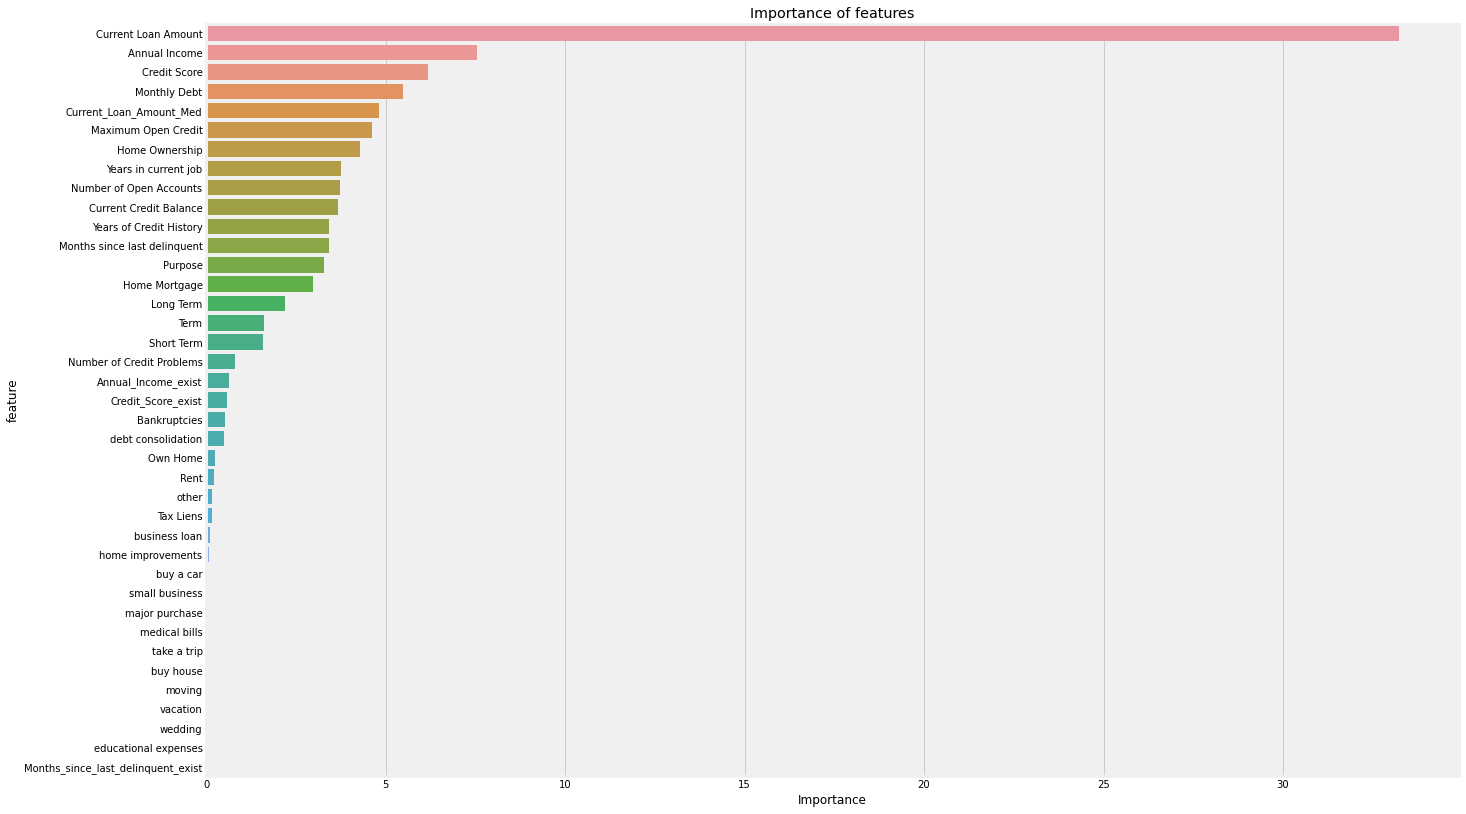

In [690]:
important_features_top = show_feature_importances(X_train.columns, best_model.feature_importances_, get_top=15)

In [700]:
importances_model = catb.CatBoostClassifier(silent=True, random_state=21,
                                     auto_class_weights = 'Balanced',
                                     iterations = 200, max_depth = 9,
                                     learning_rate = 0.03, l2_leaf_reg = 3,
                                     bagging_temperature = 1,
                                     use_best_model = True,
                                    )

NEW_CAT_FEATURE_NAMES = list(set(important_features_top) - set(NUM_FEATURE_NAMES)) 

importances_model.fit(X_train[important_features_top], y_train, cat_features = NEW_CAT_FEATURE_NAMES, eval_set=(X_valid[important_features_top], y_valid))

y_train_pred = importances_model.predict(X_train[important_features_top])
y_valid_pred = importances_model.predict(X_valid[important_features_top])

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.71      0.80      3771
           1       0.53      0.83      0.65      1479

    accuracy                           0.75      5250
   macro avg       0.72      0.77      0.72      5250
weighted avg       0.81      0.75      0.76      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.62      0.71      1616
           1       0.41      0.68      0.51       634

    accuracy                           0.64      2250
   macro avg       0.62      0.65      0.61      2250
weighted avg       0.71      0.64      0.66      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1008  608
1                205  429


### Финальная модель

In [716]:
predictions = best_model.predict(df_test)

In [717]:
predictions.shape

(2500,)

In [721]:
result = pd.DataFrame({'Id':np.arange(2500), 'Credit Default': predictions})
result.head()

,Id,Credit Default
0,0,1
1,1,1
2,2,0
3,3,0
4,4,0


In [723]:
result.to_csv('Martynov_IM_predictions.csv', index=False)